In [171]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas
from matplotlib.externals import six
import mpld3
import copy
mpld3.enable_notebook()

In [172]:
avg_cons = 23260  #Average consumption of gas in kWh for a family of 2 parents and 1 child
df = pandas.read_csv("gas_vreg.csv")
df = df.drop(['year','Month','Day','h','From','To'], 1)
df['cons_kWh'] = df.apply(lambda row: row['Cons_percentage']*avg_cons*5, axis=1)
df.head()

,UTC,Cons_percentage,cons_kWh
0,1/1/2017 5:00,0.000241,28.003307
1,1/1/2017 6:00,0.000321,37.341360
2,1/1/2017 7:00,0.000375,43.609674
3,1/1/2017 8:00,0.000369,42.886660
4,1/1/2017 9:00,0.000342,39.743490


In [264]:
CHP_one = 20000
CHP_two = 20000
generator_power = 5000                           #Power in Wh (we do all our calculations in hours)
buffer_size = 3000                                  #buffer size in liters
max_buffer_energy = buffer_size*4.2*20/3.6           #Calculation of energy stored in full buffer 
                                                 #(which we assume at the beginning of calculations)
#4.2 caloric value of water, 20 is delta t, 3.6 is Joule to Watt conversion factor
buffer_energy = 0
prev_CHP_val_one = 0
prev_CHP_val_two = 0
data_CHP_dual = df

for index, row in data_CHP_dual.iterrows():
    demand = row['cons_kWh']*1000     #times 1000 for conversion to Wh
    waste_energy = 0
    if demand <= generator_power:       #CHP unit is not turned on, except maybe to fill buffer 
                                        #(but let's not do that for now)
        excess_heat = generator_power - demand
        buffer_energy += excess_heat
        if buffer_energy > max_buffer_energy:
            waste_energy = buffer_energy - max_buffer_energy
            buffer_energy = max_buffer_energy
   
        data_CHP_dual.set_value(index, 'CHP_prod_one', 0)
        data_CHP_dual.set_value(index, 'CHP_prod_two', 0)
        prev_CHP_val_one = 0
        prev_CHP_val_two = 0
    else:
        #extra heat needs to be provided, either by buffer, CHP units or both
        #1: buffer can provide enough energy to supply demand        
        #2: buffer can't provide enough
            #2.1: one CHP unit is added to the mix, excess produced heat is stored in buffer            
            #2.2: two CHP or more units are needed            
            #2.3: all CHP units are working but demand couldn't be supplied
        extra_needed = demand - generator_power
        if extra_needed <= buffer_energy:
            buffer_energy -= extra_needed  
            if buffer_energy < max_buffer_energy - CHP_one and prev_CHP_val_one > 0:
                #since CHP unit was turned on anyway we're going to let it run a bit longer to fill the buffer
                data_CHP_dual.set_value(index, 'CHP_prod_one', CHP_one)
                buffer_energy += CHP_one
                data_CHP_dual.set_value(index, 'CHP_prod_two', 0)
                prev_CHP_val_one = CHP_one
                prev_CHP_val_two = 0
            else:            
                data_CHP_dual.set_value(index, 'CHP_prod_one', 0)
                data_CHP_dual.set_value(index, 'CHP_prod_two', 0)
                prev_CHP_val_one = 0
                prev_CHP_val_two = 0
        else: #buffer alone can't supply the nescessary extra heat 
            extra_needed -= buffer_energy
            buffer_energy = 0
            
            if extra_needed <= CHP_one:
                excess_heat = CHP_one - extra_needed
                data_CHP_dual.set_value(index, 'CHP_prod_one', CHP_one)
                data_CHP_dual.set_value(index, 'CHP_prod_two', 0)
                prev_CHP_val_one = CHP_one
                prev_CHP_val_two = 0
                #store excess heat in the buffer
                buffer_energy += excess_heat
                if buffer_energy > max_buffer_energy:
                    waste_energy = buffer_energy - max_buffer_energy
                    buffer_energy = max_buffer_energy
            elif extra_needed > CHP_one and extra_needed <= CHP_one + CHP_two:
                excess_heat = CHP_one + CHP_two - extra_needed
                data_CHP_dual.set_value(index, 'CHP_prod_one', CHP_one)
                data_CHP_dual.set_value(index, 'CHP_prod_two', CHP_two)
                prev_CHP_val_one = CHP_one
                prev_CHP_val_two = CHP_two
                #store excess heat in the buffer
                buffer_energy += excess_heat
                if buffer_energy > max_buffer_energy:
                    waste_energy = buffer_energy - max_buffer_energy
                    buffer_energy = max_buffer_energy
            else:
                print "CHP unit can't supply sufficient energy at time: ", row['UTC']
                data_CHP_dual.set_value(index, 'CHP_prod_one', CHP_one)
                data_CHP_dual.set_value(index, 'CHP_prod_two', CHP_two)
                prev_CHP_val_one = CHP_one
                prev_CHP_val_two = CHP_two
            
        
    data_CHP_dual.set_value(index,'waste_energy', waste_energy)        
    data_CHP_dual.set_value(index,'buffer_energy_now',buffer_energy)
data_CHP_dual.head()

,UTC,Cons_percentage,cons_kWh,CHP_prod_one,CHP_prod_two,waste_energy,buffer_energy_now
0,1/1/2017 5:00,0.000241,28.003307,20000,20000,0,16996.69287
1,1/1/2017 6:00,0.000321,37.341360,20000,0,0,4655.33310
2,1/1/2017 7:00,0.000375,43.609674,20000,20000,0,6045.65919
3,1/1/2017 8:00,0.000369,42.886660,20000,20000,0,8158.99912
4,1/1/2017 9:00,0.000342,39.743490,20000,20000,0,13415.50937


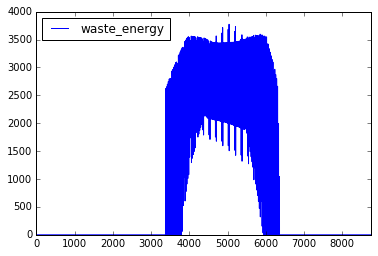

In [265]:
temp_waste = data_CHP_dual
temp_waste = temp_waste.drop(['Cons_percentage','cons_kWh', 'buffer_energy_now', 'CHP_prod_one', 'CHP_prod_two'], 1)
temp_waste.plot()

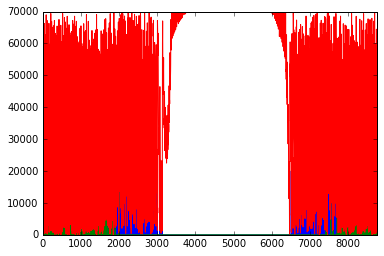

In [270]:
check_dual_CHP_behaviour = data_CHP_dual
check_dual_CHP_behaviour = check_dual_CHP_behaviour.drop(['Cons_percentage','cons_kWh', 'waste_energy'], 1)
check_dual_CHP_behaviour.plot(legend=None)

In [268]:
temp_df = data_CHP_dual
on_time = 0
CHP_on = False
counter = [0,0,0,0,0,0,0,0,0,0,0]
longterm = 0
count = 0
for index, row in temp_df.iterrows():
    if row['CHP_prod_one'] > 0:
        if CHP_on != True:
            CHP_on = True
        on_time += 1
        count += 1
    else:
        if CHP_on:
            CHP_on = False
            #print row['UTC'], ": CHP has turned off after ", on_time, " hours"
            temp = on_time
            if on_time > 10:
                temp = 11
                longterm += on_time
            counter[temp-1] += 1
            on_time = 0

for i in range(len(counter)):
    print i+1, " hours: ", counter[i], "x"
print longterm
print "sum: ", sum(counter)
print "total working hours = ", count, "\trelative = ", (count/8760.0*100), "%"

1  hours:  1 x
2  hours:  3 x
3  hours:  11 x
4  hours:  46 x
5  hours:  26 x
6  hours:  18 x
7  hours:  10 x
8  hours:  2 x
9  hours:  3 x
10  hours:  3 x
11  hours:  139 x
2785
sum:  262
total working hours =  3390 	relative =  38.698630137 %


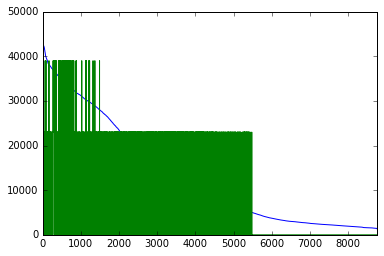

In [217]:
temp_dual = copy.deepcopy(data_CHP_dual)
temp_dual['cons_kWh'] = temp_dual.apply(lambda row:row['cons_kWh']*1000, axis=1)
temp_dual['combined_CHP'] = temp_dual.apply(lambda row: row['CHP_prod_one'] + row['CHP_prod_two'], axis=1)
temp_dual = temp_dual.drop(['Cons_percentage', 'CHP_prod_one', 'CHP_prod_two', 'waste_energy', 'buffer_energy_now'],1)
temp_dual_sorted = temp_dual.sort_values('cons_kWh', ascending=False)
dual_sorted_frame = temp_dual_sorted.reset_index(drop=True)
dual_sorted_frame.plot(legend=None)

In [178]:
temp_dual_sorted.head()

,UTC,cons_kWh,combined_CHP
146,1/7/2017 7:00,45579.34234,39000
314,1/14/2017 7:00,45378.78299,39000
8714,12/30/2017 7:00,45338.51993,39000
482,1/21/2017 7:00,44865.39990,39000
8546,12/23/2017 7:00,44639.05684,39000
